In [1]:
import numpy as np
import tensorflow as tf
import pickle
import pickle
import pandas as pd

from random import randint
import datetime
import colorlover as cl
from IPython.display import SVG
from IPython.display import HTML
from keras.utils.vis_utils import model_to_dot

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import norm

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.merge import *
from keras.utils import to_categorical
from keras import objectives

from utils import *

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tqdm import TQDMNotebookCallback
from keras import regularizers
from keras import backend as K
from keras import metrics

plotly.tools.set_credentials_file(username='AbdelWahabTurkmani', api_key='zTY632QGUJbqSVFms8bQ')
# plotly.tools.set_credentials_file(username='asturkmani', api_key='bR0Ez8evmzcHY6m4XG7B')
# plotly.tools.set_credentials_file(username='asturkmanics', api_key='GaUFc6cWCQVW0eCz6K75')

Using TensorFlow backend.


In [2]:
window_size = 6
time_percentage = 0.9
batch_size = 20
data_ = make_clean_data(window_size, batch_size,multiplier=1, process=False)

def sampling(args):
    z_mean, z_log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma / 2) * 1.

/home/asturkmani/Thesis/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [10]:
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100

print("Dataset size:", data_['yc'].shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(data_['popular_apps']), '\n')

graphdata = [go.Bar(
            x=data_['popular_apps'],
            y=time_spent,
            marker=dict(
        color= data_['data_colors']),
    )]

py.iplot(graphdata, filename='basic-bar')

Dataset size: (18280, 15) 

Number of apps that consume 90.0 % of all users time:  15 



# Seq2Seq Variational Autoencoder

- [Building Autoencoders in Keras] (https://blog.keras.io/building-autoencoders-in-keras.html)
- [Generating sentences from a continuous space] (https://arxiv.org/abs/1511.06349)
- [Keras VAE LSTM ] (https://github.com/twairball/keras_lstm_vae)

    
# --- include variational CNN code below ---

In [143]:
activ = 'relu'
optim = Adam(lr=0.0005)

input_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
batch_size = 20
latent_dim = 2
intermediate_dim=32
epsilon_std = 1.

"""
Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
# Arguments
    input_dim: int.
    timesteps: int, input timestep dimension.
    batch_size: int.
    intermediate_dim: int, output shape of LSTM. 
    latent_dim: int, latent z-layer shape. 
    epsilon_std: float, z-layer sigma.
# References
    - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
    - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
"""
x = Input(shape=(timesteps, input_dim,))

# LSTM encoding
h = LSTM(intermediate_dim, activation=activ)(x)

# VAE Z layer
z_mean = Dense(latent_dim, activation='linear')(h)
z_log_sigma = Dense(latent_dim, activation='linear')(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon_std

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

# decoded LSTM layer
decoder_h = LSTM(intermediate_dim, activation=activ, return_sequences=True)
decoder_mean = LSTM(input_dim, activation='sigmoid',return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

# decoded layer
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))

_h_decoded = RepeatVector(timesteps)(decoder_input)
_h_decoded = decoder_h(_h_decoded)

_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss

def recon_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

def KL_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    return kl_loss

vae.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])
print(vae.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_46 (InputLayer)            (None, 6, 15)         0                                            
____________________________________________________________________________________________________
lstm_75 (LSTM)                   (None, 32)            6144        input_46[0][0]                   
____________________________________________________________________________________________________
dense_41 (Dense)                 (None, 2)             66          lstm_75[0][0]                    
____________________________________________________________________________________________________
dense_42 (Dense)                 (None, 2)             66          lstm_75[0][0]                    
___________________________________________________________________________________________

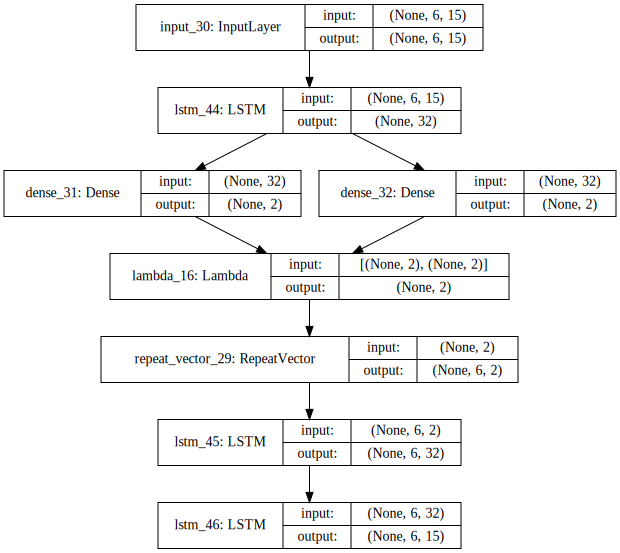

In [84]:
SVG(model_to_dot(vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [85]:
vae.fit(x=data_['x_train_c'], 
                   y=data_['x_train_c'],
                   verbose = 0,
                   shuffle=False,
                   batch_size=batch_size,
                   epochs=100,
                   validation_data = (
                       data_['x_test_c'],
                       data_['x_test_c']),
                   callbacks = [EarlyStopping(patience = 5),]
                  )

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [86]:
z_train = enc.predict(data_['Xc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)
print(encodings.shape)

(18280, 2)


In [87]:
new_l = len(encodings)-1
encodings_shifted = encodings[-new_l:]

colors_shifted = data_['yc_colors'][:new_l]

In [88]:
x = encodings_shifted[:,0]
y = encodings_shifted[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = colors_shifted, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-LSTM-Data')

## Seq2seq with Time and Day

In [145]:
activ = 'relu'
optim = Adam(lr=0.0005)

input_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
time_dim = data_['time']
day_dim = data_['days']

batch_size = 20
latent_dim = 2
intermediate_dim=32
epsilon_std = 1.

"""
Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
# Arguments
    input_dim: int.
    timesteps: int, input timestep dimension.
    batch_size: int.
    intermediate_dim: int, output shape of LSTM. 
    latent_dim: int, latent z-layer shape. 
    epsilon_std: float, z-layer sigma.
# References
    - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
    - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
"""
x = Input(shape=(timesteps, input_dim,), name='Input')
day = Input(shape=(timesteps, day_dim,), name='Day')
time = Input(shape=(timesteps, time_dim,), name='Time')

inputs = Concatenate()([x, day, time])
# LSTM encoding
h = LSTM(intermediate_dim, activation=activ, name='LSTM_Encoder')(inputs)

# VAE Z layer
z_mean = Dense(latent_dim, activation='linear', name='Z_Mean')(h)
z_log_sigma = Dense(latent_dim, activation='linear', name='Z_log_sigma')(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon_std

z = Lambda(sampling, output_shape=(latent_dim,), name='Sampling')([z_mean, z_log_sigma])

def get_last(x):
    return x[:, -1]

zc = Concatenate()([z, Lambda(get_last)(day), Lambda(get_last)(time)])
# decoded LSTM layer
decoder_h = LSTM(intermediate_dim, activation=activ, return_sequences=True)
decoder_mean = LSTM(input_dim, activation='sigmoid',return_sequences=True)

h_decoded = RepeatVector(timesteps)(zc)
h_decoded = decoder_h(h_decoded)

# decoded layer
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
c_lstm_vae_td = Model([x, day, time], x_decoded_mean)

# encoder, from inputs to latent space
c_lstm_encoder_td = Model([x, day, time], z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim+time_dim+day_dim,))

_h_decoded = RepeatVector(timesteps)(decoder_input)
_h_decoded = decoder_h(_h_decoded)

_x_decoded_mean = decoder_mean(_h_decoded)
c_lstm_generator_td = Model(decoder_input, _x_decoded_mean)


def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss

def recon_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

def KL_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    return kl_loss

c_lstm_vae_td.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])
print(c_lstm_vae_td.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 6, 15)         0                                            
____________________________________________________________________________________________________
Day (InputLayer)                 (None, 6, 7)          0                                            
____________________________________________________________________________________________________
Time (InputLayer)                (None, 6, 24)         0                                            
____________________________________________________________________________________________________
concatenate_32 (Concatenate)     (None, 6, 46)         0           Input[0][0]                      
                                                                   Day[0][0]               

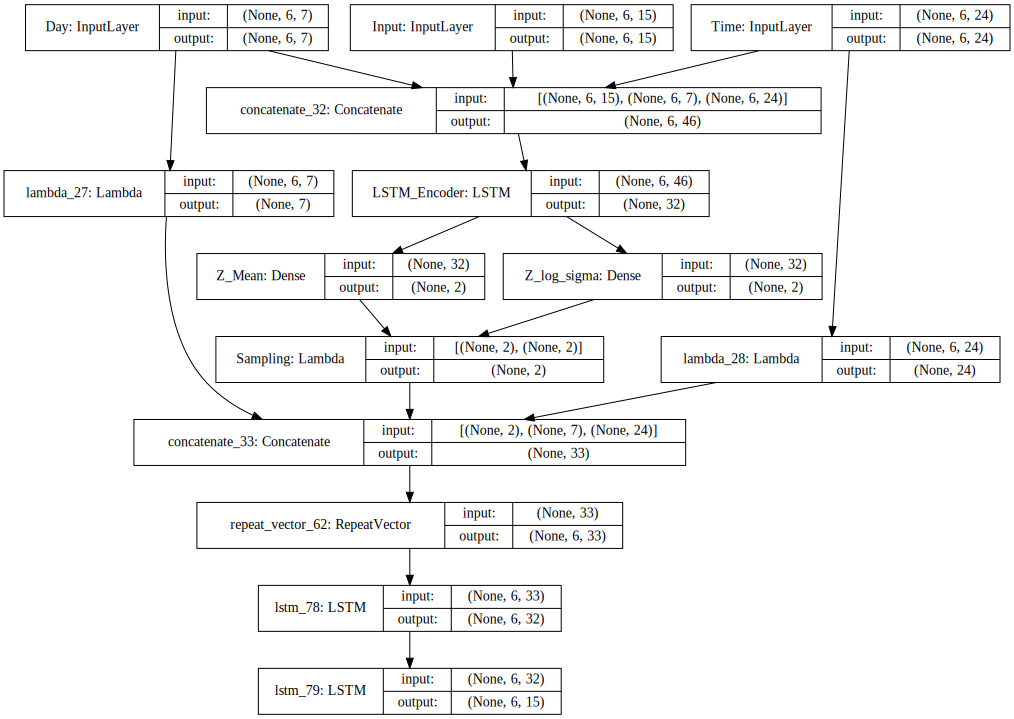

In [146]:
SVG(model_to_dot(c_lstm_vae_td, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [157]:
x_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['Xd']])
x_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['Xt']])

x_train_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_train_d']])
x_train_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_train_t']])

x_test_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_test_d']])
x_test_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_test_t']])

x_test_t.shape

(3640, 6, 24)

In [158]:
# compile and fit
c_lstm_vae_td.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])
c_lstm_vae_td_hist = c_lstm_vae_td.fit(
    [data_['x_train_c'], x_train_d, x_train_t], 
    data_['x_train_c'], 
    verbose = 0, 
    batch_size=batch_size, 
    epochs=100,
    validation_data = ([data_['x_test_c'], x_test_d,x_test_t], 
                        data_['x_test_c']),
    callbacks = [EarlyStopping(patience = 5),TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [159]:
z_train = c_lstm_encoder_td.predict([data_['Xc'], x_d, x_t])
encodings= np.asarray(z_train)
# encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)

new_l = len(encodings)-1
encodings_shifted = encodings[-new_l:]

colors_shifted = data_['yc_colors'][:new_l]

In [160]:
x = encodings_shifted[:,0]
y = encodings_shifted[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = colors_shifted, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-LSTM_TD_-Data')

# Analysis:

We note that with the LSTM VAE we observe a more gaussian shape, however the VAE still tries to separate the data into clusters concentrated by the specific apps

In the LSTM_VAE conditioned on Time & Day - we see an even better Gaussian latent space with the interesting property that apps that tend to be used together and clustered in the same area, for example Purple & Pink (S.Eng and Writing) are on the left and (Video & IM) on the right